# Text Representation of norms from ANEEL (National Electric Power Agency of Brazil).

The models, encoders, strategies and code snippets were obtained in [Pierre Guillou Language Models](https://github.com/piegu/language-models). 

The ideia is to use a Portuguese Language Model with MultiFit and SentencePiece Tokenization to represent texts from ANEEL e relate the most similar.

Developed by IEEE Computational Intelligence Society Student Chapter of University of Brasilia, Brazil.


### Import and manage the modules and libraries.

In [0]:
import gdown
  # Allows to download files from its URL

from fastai import *
from fastai.text import *
from fastai.callbacks import *

! pip install sentencepiece
  # Intall module to make the SP tokenization

! pip install Ninja
! pip install -U fastai
  # Ninja is required to use QRNN architecture.

%reload_ext autoreload
%autoreload 2
%matplotlib inline


### Importing and extracting of the model.

The '.tgz' file was downloaded from the link above and uploaded into the Google Colab plataform.

In [0]:
def download(id):
  url = 'https://drive.google.com/uc?id=' + str(id)
  gdown.download(url, output = None, quiet = False)

In [4]:
download("1NmH1Ug1YeontgAlgbvZxNZ115WNoZNjq")

Downloading...
From: https://drive.google.com/uc?id=1NmH1Ug1YeontgAlgbvZxNZ115WNoZNjq
To: /content/pt_lm_sp15_multifit.tgz
194MB [00:03, 62.5MB/s]


In [5]:
! ls

pt_lm_sp15_multifit.tgz  sample_data


In [6]:
! tar zxvf pt_lm_sp15_multifit.tgz

pt_lm_sp15_multifit/
pt_lm_sp15_multifit/pt_wt_sp15_multifit.pth
pt_lm_sp15_multifit/pt_wt_sp15_multifit_bwd.pth
pt_lm_sp15_multifit/pt_wt_vocab_sp15_multifit.pkl
pt_lm_sp15_multifit/pt_wt_vocab_sp15_multifit_bwd.pkl
pt_lm_sp15_multifit/spm.model
pt_lm_sp15_multifit/spm.vocab


### Obtaining ANEEL norms DataSet.

The target texts have been allocated in a CSV file with additional relevant information.

The file (DataSet) is available in a GitHub repository.

In [7]:
! git clone https://github.com/thiagodma/Similarity-ANEEL
! mv Similarity-ANEEL/LanguageModelFile.csv ./

Cloning into 'Similarity-ANEEL'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 78 (delta 9), reused 18 (delta 6), pack-reused 55
Unpacking objects: 100% (78/78), done.


In [0]:
! mkdir pt_lm_sp15_multifit/tmp

In [9]:
! cd pt_lm_sp15_multifit/ ; mv spm.model spm.vocab tmp/
! ls pt_lm_sp15_multifit/tmp

spm.model  spm.vocab


In [0]:
! mkdir models
! mv pt_lm_sp15_multifit/* models/

In [24]:
! ls models/

pt_wt_sp15_multifit_bwd.pth  pt_wt_vocab_sp15_multifit_bwd.pkl	tmp
pt_wt_sp15_multifit.pth      pt_wt_vocab_sp15_multifit.pkl


## Initialisation

In [0]:
bs = 48

torch.cuda.set_device(0)

In [0]:
lm_fns3 = ['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']

In [0]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')

In [0]:
# source: https://github.com/fastai/fastai/blob/master//fastai/layers.py#L300:7
# blog: https://bfarzin.github.io/Label-Smoothing/
class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [0]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on"

### Data

In [30]:
df = pd.read_csv('LanguageModelFile.csv', delimiter='|')
df.head()

,Unnamed: 0,Norma,Data de publicação,Ementa,Órgão de origem,Assuntos,Texto Integral,Tipo,Filename,Texto Extraído
0,0,INA - INSTRUÇÃO ADMINISTRATIVA 001/2019,05/04/2019,"Dispõe sobre procedimentos para atualização, m...",SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2019001sgi.pdf,INA,ina2019001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
1,1,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,25/05/2018,Dispõe sobre procedimentos para a manutenção d...,SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2018001sgi.pdf,INA,ina2018001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
2,2,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,04/05/2018,Altera o limite do valor de reembolso relativo...,SRH/ANEEL,Alteração \n,http://www2.aneel.gov.br/cedoc/ina2018001srh.pdf,INA,ina2018001srh.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
3,3,INA - INSTRUÇÃO ADMINISTRATIVA 002/2019,20/05/2019,Dispõe sobre a composição e o funcionamento do...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019002sgi.pdf,INA,ina2019002sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA ANEEL ...
4,4,INA - INSTRUÇÃO ADMINISTRATIVA 003/2019,13/09/2019,Dispõe sobre a definição de acrônimos das coor...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019003sgi.pdf,INA,ina2019003sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...


In [31]:
df.isnull().sum()

Unnamed: 0             0
Norma                  0
Data de publicação     0
Ementa                 0
Órgão de origem        0
Assuntos               0
Texto Integral         0
Tipo                   0
Filename               0
Texto Extraído        12
dtype: int64


Here it was identified that exist NaN cells in the DataFrame, whose colunms should be stripped.

In [32]:
df_tv = df.dropna()
df_tv.isnull().sum()

Unnamed: 0            0
Norma                 0
Data de publicação    0
Ementa                0
Órgão de origem       0
Assuntos              0
Texto Integral        0
Tipo                  0
Filename              0
Texto Extraído        0
dtype: int64

In [0]:
df_tv.to_csv('LanguageModelFile_cleaned.csv', sep='|')

## Fine-tuning "forward LM"

In [0]:
reviews = "Texto Extraído"
label = "Assuntos"

In [0]:
data_lm = (TextList.from_df(df_tv, '.', cols=reviews, processor=SPProcessor.load('models/'))
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

# Why fastai.text doesn't come with SentencePiece module?

In [59]:
data_lm.show_batch()

idx,text
0,"▁re posição , ▁bem ▁como ▁mantendo ▁pessoal ▁técnico ▁e ▁administrativo , ▁próprio ▁ou ▁de ▁terceiro s , ▁legal mente ▁habilita do ▁e ▁treinado ▁e ▁em ▁número ▁suficiente ▁para ▁assegurar ▁a ▁continuidade , ▁a ▁regular idade , ▁a ▁eficiência ▁e ▁a ▁segurança ▁da ▁exploração ▁da ▁xxup ▁p ch ; ▁xxup ▁xi ▁ - ▁sub me ter - se ▁à ▁fiscalização , ▁permitindo ▁aos ▁técnicos ▁da ▁xxup ▁a ne el , ▁em"
1,▁xxup ▁ lt ▁1 38 ▁k v ▁xxup ▁santa ▁xxup ▁cruz ▁/ ▁xxup ▁palma res ▁xxup ▁ rj ▁xxup ▁ ld ▁xxmaj ▁em ▁operação ▁ light - d ▁xxup ▁fur nas ▁xxup ▁ lt ▁1 38 ▁k v ▁xxup ▁santa ▁xxup ▁cruz ▁/ ▁xxup ▁zona ▁xxup ▁indu s tr . ▁xxup ▁ rj ▁xxup ▁ ld ▁xxmaj ▁em ▁operação ▁ light - d ▁xxup ▁fur nas ▁xxup ▁ lt ▁1
2,"▁época s ▁próprias ▁definida s , ▁da ▁xxmaj ▁taxa ▁de ▁xxmaj ▁fiscalização ▁de ▁xxmaj ▁serviços ▁de ▁xxmaj ▁energia ▁xxmaj ▁elétrica , ▁nos ▁termos ▁da ▁legislação ▁específica ; ▁xxup ▁iv ▁ - ▁celebra r ▁os ▁contrato s ▁de ▁uso ▁e ▁de ▁conexão ▁dos ▁sistemas ▁de ▁transmissão ▁e ▁distribuição ▁para ▁atendimento ▁eventual ▁da ▁carga ▁quando ▁de ▁ indi s pon ibilidade ▁da ▁geração , ▁nos ▁termos ▁da ▁legislação ▁e ▁normas ▁específicas ;"
3,"hí d rico s , ▁providencia ndo ▁as ▁licença s ▁correspondente s ; ▁x ▁ - ▁sub me ter - se ▁a ▁toda ▁e ▁qualquer ▁regulamenta ção ▁de ▁caráter ▁geral ▁ou ▁que ▁ ve nha ▁a ▁ser ▁estabelecida ▁pela ▁xxup ▁a ne el , ▁especialmente ▁aquela s ▁relativa s ▁à ▁produção ▁independente ▁de ▁energia ▁elétrica ; ▁xxup ▁xi ▁ - ▁presta r ▁todas ▁as ▁informações ▁relativa s ▁ao ▁andamento ▁do"
4,", ▁de ▁acordo ▁com ▁de libera ção ▁da ▁xxmaj ▁diretoria , ▁tendo ▁em ▁vista ▁o ▁disposto ▁no ▁art . ▁29 , ▁ inci so ▁xxup ▁i , ▁da ▁xxmaj ▁lei ▁no ▁8 . 98 7 , ▁de ▁13 ▁de ▁fevereiro ▁de ▁1995, ▁no ▁art . ▁2 o ▁da ▁xxmaj ▁lei ▁no ▁9 . 4 27 , ▁de ▁26 ▁de ▁dezembro ▁de ▁1996, ▁no ▁xxmaj ▁anexo ▁xxup ▁i , ▁art ."


In [0]:
data_lm.save('aneel_norms_sp15_multifit_v1')

#### Training

In [0]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

#### At first, the loss function won't be changed.

In [0]:
perplexity = Perplexity()

learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, 
                                  pretrained_fnames=lm_fns3, drop_mult=1.,
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

In [40]:
learn_lm.loss_func

FlattenedLoss of CrossEntropyLoss()

In [39]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02
Min loss divided by 10: 4.37E-02


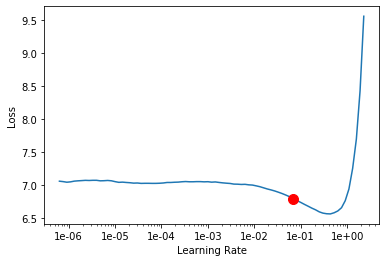

In [41]:
learn_lm.recorder.plot(suggestion=True)

In [0]:
# First adjustment:
#lr = 6.92e-2
#wd = 0.1

# Second adjustment:
lr = 2e-2
wd = 0.1

In [49]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))
#learn_lm.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,40.612171,18.516800,0.985198,0.014802,110089232.000000,01:22
1,4.869772,4.334821,0.740024,0.259976,76.311317,01:22


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,2.523909,2.358563,0.462573,0.537427,10.575747,01:51
1,2.639926,2.564749,0.486158,0.513842,12.997386,01:50
2,3.195114,3.191933,0.568339,0.431661,24.335426,01:51


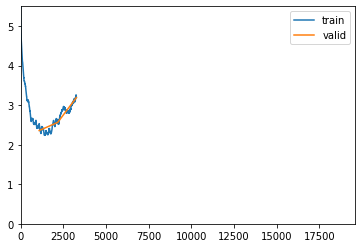

KeyboardInterrupt: ignored

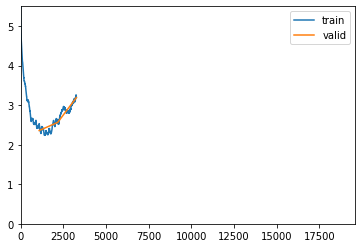

In [50]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

### New Loss Function

With the previous function the model always diverged. We will use the Label Smoothing Cross Entropy Loss Function.

#### Import already trained model

The model was already trained and saved. So run the commented cells below to load the weights to the **learn_lm**.

In [8]:
# Model download
#download("16GNcGwgzz9YpObM2OtN7C8CczIbbU3BK")

# Encoder download
#download("1VaTySonoC0GlPveoEO91pf4K2YiBTGN9")

Downloading...
From: https://drive.google.com/uc?id=16GNcGwgzz9YpObM2OtN7C8CczIbbU3BK
To: /content/unfreezed_finetuned_aneel_sp15_multifit.pth
260MB [00:06, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VaTySonoC0GlPveoEO91pf4K2YiBTGN9
To: /content/unfreezed_finetuned_enc_aneel_sp15_multifit.pth
52.0MB [00:00, 196MB/s] 


In [9]:
#learn_lm.load('unfreezed_finetuned_aneel_sp15_multifit')
#learn_lm.lead('unfreezed_finetuned_enc_aneel_sp15_multifit')

Batera.png   unfreezed_finetuned_aneel_sp15_multifit.pth
sample_data  unfreezed_finetuned_enc_aneel_sp15_multifit.pth


#### Traning the language model

In [0]:
perplexity = Perplexity()

learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, 
                                  pretrained_fnames=lm_fns3, drop_mult=1.,
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

In [61]:
learn_lm.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)
learn_lm.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 3.63E-02


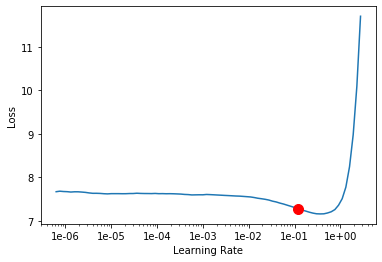

In [62]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

In [0]:
# First try:
#lr = 1e-1
#wd = 0.1

# Second Try:
lr = 2e-2
wd = 0.1

In [64]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,9.434313,6.988596,0.929822,0.070179,601.483337,01:24
1,5.571575,4.982403,0.723872,0.276128,64.111336,01:24


In [0]:
learn_lm.save('freezed_finetuned_aneel_sp15_multifit')
learn_lm.save_encoder('freezed_finetuned_enc_aneel_sp15_multifit')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.939215,3.668982,0.517043,0.482957,14.809157,01:54
1,3.365867,3.269887,0.433799,0.566201,9.600501,01:54
2,3.103360,3.252710,0.430909,0.569091,9.481110,01:54
3,3.235155,3.345508,0.445931,0.554069,10.168368,01:52
4,3.380624,3.367903,0.451209,0.548791,10.583832,01:53
5,3.272857,3.428427,0.450795,0.549205,10.862501,01:52
6,3.350583,3.399260,0.455398,0.544602,10.640718,01:54
7,3.442497,3.353406,0.445165,0.554835,10.124866,01:54
8,3.459086,3.301254,0.437238,0.562762,9.610175,01:54
9,3.108235,3.206253,0.421935,0.578065,8.688735,01:54


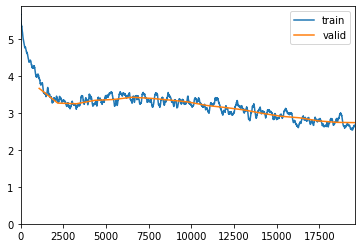

In [66]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(18, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [0]:
learn_lm.save('unfreezed_finetuned_aneel_sp15_multifit')
learn_lm.save_encoder('unfreezed_finetuned_enc_aneel_sp15_multifit')

## Get vector representation of texts.

In [0]:
normas = list(pd.read_csv('LanguageModelFile_cleaned.csv',sep='|',encoding='utf-8')['Texto Extraído'])

In [84]:
#Here I get the vector representation of the text using the trained encoder
mbe = MultiBatchEncoder(70,1400,learn_lm.model[0])

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

X = np.zeros((1,1200))
i=0
for norma in normas:
    xb,yb = learn_lm.data.one_item(norma)
    sentence = torch.cuda.LongTensor(xb.tolist()[0]).unsqueeze(0)
    raw_outputs, outputs, masks = mbe.forward(sentence)
    sentence_rep = masked_concat_pool(outputs, masks)
    X = np.append(X,sentence_rep,axis=0)
    if len(normas) % (i+1) == 10: print(str(i+1) + ' out of ' + str(len(normas)))
    i+=1

389 out of 1566
778 out of 1566
1556 out of 1566


In [0]:
X = np.delete(X, (0), axis=0)
np.save('X_LM', X)